<a href="https://colab.research.google.com/github/mirzarayhan/DeteksiPesawat/blob/main/DeteksiPesawat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology, io
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import binary_closing, disk
import scipy.ndimage as nd
import math

In [ ]:
# connect dari google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import foto (edit dolo)
img = cv2.imread('/content/drive/MyDrive/Images/dataset/test/gray_20.tif',0) 
img.dtype

dtype('uint8')

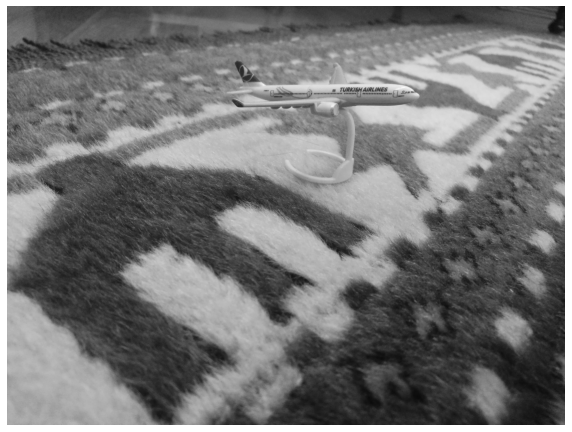

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# mengubah ukuran image

src = img
scale_percent = 20

#hitung 50 persen dari dimensi aslinya
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# mengubah ukuran
img = cv2.resize(src, dsize)


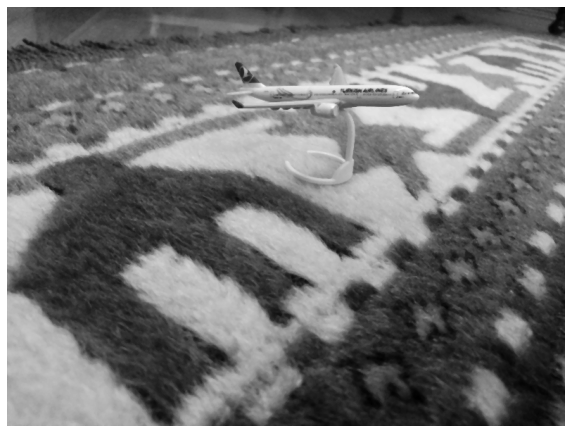

In [ ]:
# Median filter
img_blur = cv2.medianBlur(img,3)
cv2.imwrite("blured.pgm",img_blur)

#menampilkan gambar
plt.figure(figsize=(10,10))
plt.imshow(img_blur,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def auto_canny(image, sigma=0.1):
	# Median gambar diambil
  v = np.median(image)
  # Nilai ambang batas bawah dan atas ditentukan menggunakan nilai median
  lower = int(max(0, (1.0 - sigma) * v))
  upper = int(min(255, (1.0 + sigma) * v))
  edged = cv2.Canny(image, lower, upper)
  return edged

In [ ]:
# Canny dibuat sebagai hasil dari filter median
canny_img = auto_canny(img_blur)
canny_img.dtype
cv2.imwrite("canny.pgm",canny_img)

True

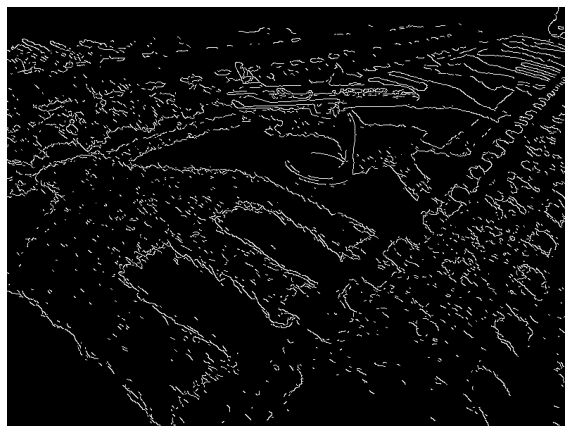

In [ ]:
#menampilkan gambar
plt.figure(figsize=(10,10))
plt.imshow(canny_img,cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# operasi dilatasi (3.3) dengan elemen struktur elips
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
dilated = cv2.dilate(canny_img, kernel,iterations=1) 
cv2.imwrite("dilated.pgm",dilated)

True

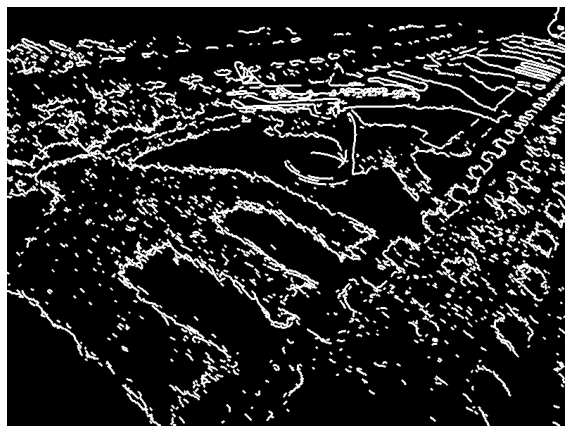

In [ ]:
#menampilkan gambar
plt.figure(figsize=(10,10))
plt.imshow(dilated,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Menghapus tag
retval, labels = cv2.connectedComponents(dilated)
# Jika jumlah total piksel yang dihitung kurang dari N, tetapkan 0 pada label itu
num = labels.max()
N = 500
for i in range(1, num+1):
    pts =  np.where(labels == i)
    if len(pts[0]) < N:
        labels[pts] = 0



# Menetapkan gambar yang diekstraksi ke latar belakang (hitam)
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# Dikonversi dari format HSV ke BGR untuk dilihat.
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# Latar belakang dibuat hitam
labeled_img[label_hue==0] = 0

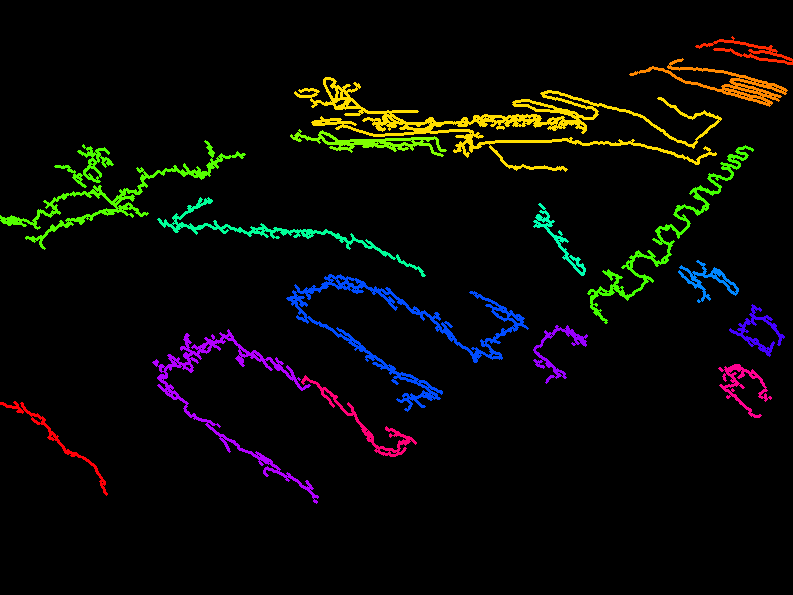

True

In [ ]:
cv2_imshow(labeled_img)
cv2.imwrite("labeled_img_rgb.png",labeled_img)

In [ ]:
# Dikonversi kembali ke format Grayscale untuk menutup algoritma closing
labeled_img = cv2.cvtColor(labeled_img,cv2.COLOR_BGR2GRAY)

In [ ]:
# Closing dilakukan dengan mask
strel = disk(4)
I_closed = binary_closing(labeled_img, strel)
# Menerapkan morfologi untuk mengisinya sepenuhnya
I_closed_filled = nd.morphology.binary_fill_holes(I_closed)

I_closed_filled.dtype='uint8'
I_closed_filled.dtype

dtype('uint8')

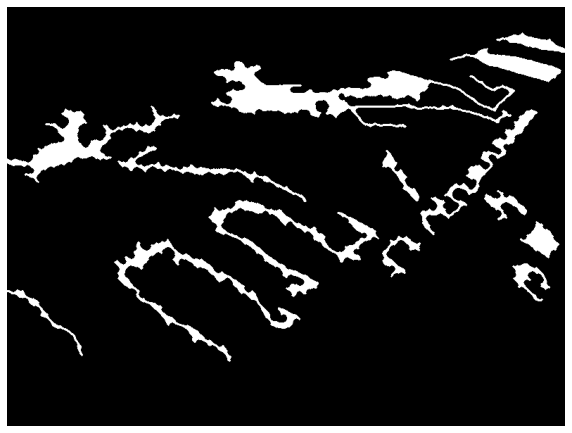

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(I_closed_filled,cmap='gray')
plt.axis('off')
plt.savefig('closed_labeled_img.png')
plt.show()

Label: 3 >> Object area: 11457, Eccentricity: 0.9867047937562314 


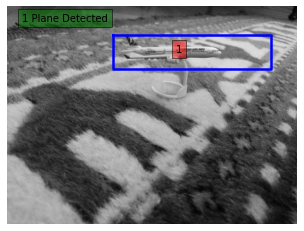

In [ ]:
# diekspor ke fungsi regionprops untuk ekstraksi atribut dengan mengekstrak tag gambar
label_img = measure.label(I_closed_filled)
regions = measure.regionprops(label_img)
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)
k = 1
# Jika luas yang ditemukan lebih besar dari 6500, ambil pusatnya dan lingkari dalam persegi panjang
# Tetapkan nomor objek ke titik tengah
# Cetak nilai area dan eksentrisitas.
count = []

for props in regions:
    if (props.area > 6500):
      y0, x0 = props.centroid
      orientation = props.orientation
      x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
      y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
      x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
      y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

      plt.text(x0, y0, "{}".format(k), bbox=dict(facecolor='red', alpha=0.5))

      k = k+1
      minr, minc, maxr, maxc = props.bbox
      bx = (minc, maxc, maxc, minc, minc)
      by = (minr, minr, maxr, maxr, minr)
      ax.plot(bx, by, '-b', linewidth=2.5)
      print('Label: {} >> Object area: {}, Eccentricity: {} '.format(props.label, props.area, props.eccentricity))
      count.append(orientation)
plt.text(40, 40, "{} Plane Detected".format(len(count)), bbox=dict(facecolor='green', alpha=0.5),fontsize=10)
# plt.title('Label: {} >> Object area: {}, Eccentricity: {} '.format(props.label, props.area, props.eccentricity)
ax.axis('off')
plt.savefig("output.png",)
plt.show()